# Betting the NFL Over/Under - A Data Science Perspective
## Exploratory Data Analysis

**Import all the relevant packages and establish settings.** 

In [14]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
%matplotlib inline
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import pingouin as pg
sns.set(font_scale=1.4)

**Define functions used in notebook.**

In [19]:
# Function to add '+' to tickmarks
def y_tk_fmt(x,y):
    if x > 0:
        return '{:+d}'.format(int(x))
    else:
        return '{:d}'.format(int(x))

# Determines correct year corresponding to the football season of the game
def get_year(code):
    if (code[4:6] == '01'):
        year = str(int(code[0:4])-1)
    else:
        year = str(int(code[0:4]))
    return year


**Set of routines governing the sorting, grouping, and train/test splitting of data in this study**

In [29]:
from math import floor 

def tt_split(X,y,train_ratio,valid_ratio=0.0,seed=None,val=False):
# Train/test splitting function used in this study
    X, y = shufflesort(X,y,seed)
    if val:
        ratio = 1-train_ratio
        binwidth = max(deno_decimalToFraction(ratio),deno_decimalToFraction(1-ratio))
        ygrp = group_labels(y,ratio,seed=seed)
        X_train, X_valid, y_train, y_valid = split_labels(X,y,ygrp,binwidth,ratio)

        ratio = 1-(valid_ratio/(1-train_ratio))
        binwidth = max(deno_decimalToFraction(ratio),deno_decimalToFraction(1-ratio))
        ygrp = group_labels(y_valid,ratio,seed=seed)
        X_val, X_test, y_val, y_test = split_labels(X_valid,y_valid,ygrp,binwidth,ratio)
        return X_train, X_val, X_test, y_train, y_val, y_test 
    else:
        test_ratio = 1-train_ratio
        binwidth = max(deno_decimalToFraction(test_ratio),deno_decimalToFraction(1-test_ratio))
        ygrp = group_labels(y,test_ratio,seed=seed)
        X_train, X_test, y_train, y_test = split_labels(X,y,ygrp,binwidth,test_ratio)

        return X_train, X_test, y_train, y_test


def group_labels(y,ratio,seed=None):
    np.random.seed(seed=seed)
    length = len(y)
    grpwidth = max(deno_decimalToFraction(ratio),deno_decimalToFraction(1-ratio))
    reg_grps = int(length/grpwidth) 
    grp=np.empty(length,dtype=int)
    for i in range(reg_grps):
        b_idx = i * grpwidth
        f_idx = b_idx + grpwidth
        grp[b_idx:f_idx] = np.random.choice(grpwidth,grpwidth,replace=False)
    grp[f_idx:length] = np.random.choice(grpwidth,length-f_idx,replace=False)
    return grp

def split_labels(X,y,grp,binwidth,ratio):
    sel = np.isin(grp,np.arange(round(binwidth*ratio)))
    y_test = y[sel]
    X_test = X[sel]
    sel = np.isin(grp,np.arange(round(binwidth*ratio)),invert=True)
    y_train = y[sel]
    X_train = X[sel]        
    return X_train, X_test, y_train, y_test

# Recursive function to return greatest common denominator of a and b 
def gcd(a, b): 
      
    if (a == 0): 
        return b 
    elif (b == 0): 
        return a 
    if (a < b): 
        return gcd(a, b % a) 
    else: 
        return gcd(b, a % b) 

def deno_decimalToFraction(number):
# Returns denominator of fraction converted from decimal   
      
    # Fetch integral value of the decimal 
    intVal = floor(number) 
  
    # Fetch fractional part of the decimal 
    fVal = number - intVal 
  
    # Consider precision value to 
    # convert fractional part to 
    # integral equivalent 
    pVal = 1000000000
  
    # Calculate GCD of integral 
    # equivalent of fractional 
    # part and precision value 
    gcdVal = gcd(round(fVal * pVal), pVal) 
  
    # Calculate num and deno 
    num= round(fVal * pVal) // gcdVal 
    deno = pVal // gcdVal 

#     # Print the fraction 
#     print((intVal * deno) + num, "/", deno) 
  
    return deno 
  

def shufflesort(X,y,seed=None):
# Sorts dataset by label and shuffles labels with the same value
    np.random.seed(seed=seed)
    y_sorted = y.reset_index(drop=True).sort_values()
    idx = y_sorted.index.to_numpy()
    vc = y_sorted.value_counts()
    vals = list(vc[vc > 1].index)
    for val in vals:
        b_idx = y_sorted.index.get_loc(y_sorted[y_sorted==val].index[0])   # First index of value
        f_idx = y_sorted.index.get_loc(y_sorted[y_sorted==val].index[-1])  # Last index of value
        idx[b_idx:f_idx+1] = np.random.permutation(idx[b_idx:f_idx+1])     # Permute order of indices for value
    y_sorted = y_sorted.reindex(idx)
    y = y.iloc[y_sorted.index]
    X = X.iloc[y_sorted.index]
    return X,y

### A. Overview

**Read into variables data from the dataset.**

In [5]:
# dfall represents the data from all games in the dataset
path = 'data/df_2010_2019.pkl'
with open(path,'rb') as f:
    dfall = pickle.load(f)
    
# dfgame represents the averaged data and individual gamedata used in the analysis
path = 'data/df_2010_2019_5wk.pkl'
with open(path,'rb') as f:
    dfgame = pickle.load(f)

**The barplot shows that certain scores are favored in American football. The significant advantage of the home team is indicated in the scoring as well as in the pie chart.** 

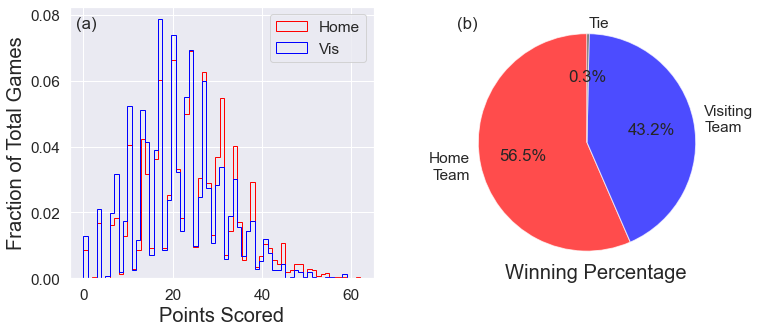

In [6]:
scores = dfall[['H_Game','V_Game']].rename({'H_Game':'Home','V_Game':'Vis'},axis=1)
fig1 = plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,2,1)
_ = plt.xlabel('Points Scored',fontsize='large')
_ = plt.ylabel('Fraction of Total Games',fontsize='large')
_ = plt.hist(scores['Home'],bins=63,density=True,histtype='step',ec='red',alpha=1.0,
         label='Home')
_ = plt.hist(scores['Vis'],bins=60,density=True,histtype='step',ec='blue',alpha=1.0,
         label='Vis')
_ = plt.legend(loc='upper right')
ax1.text(0.02,0.92,'(a)',transform=ax1.transAxes)
ax2 = plt.subplot(1,2,2)
win = np.array([(scores['Home'] > scores['Vis']).sum(),(scores['Home'] < scores['Vis']).sum(),
                 (scores['Home'] == scores['Vis']).sum()])
labels = 'Home'+'\n'+'Team', 'Visiting'+'\n'+'Team', 'Tie'
colors = ('red','blue','black')
alpha = 0.7
p = plt.pie(win/sum(win),labels=labels,autopct='%1.1f%%',radius=1.0,colors=colors,startangle=90)
for i in range(3):
    p[0][i].set_alpha(alpha)
_ = plt.text(0.20,0.00,'Winning Percentage',transform=ax2.transAxes,fontsize='large')
ax2.text(0.02,0.92,'(b)',transform=ax2.transAxes)
fig1.show()

**In the following, we can see the range of** *Total Score* **is much larger than that of** *Over/Under*, **with a positive correlation for** *Total Score* **vs.** *Over/Under* **of 0.29.**

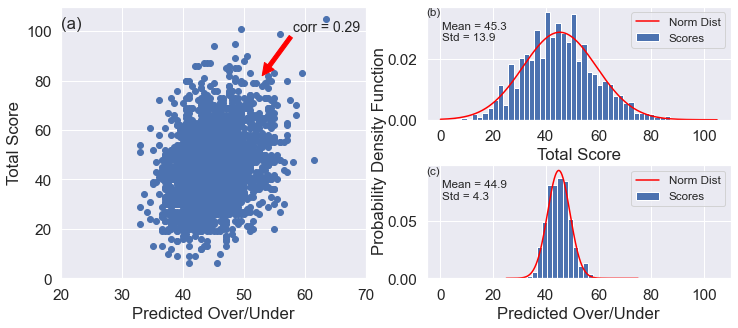

In [7]:
import matplotlib.gridspec as gridspec
from scipy import stats   

fig2 = plt.figure(figsize=(12,5))
outer = gridspec.GridSpec(1, 2, wspace=0.2, hspace=0.2)

inner_l = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[0])
ax = plt.Subplot(fig2, inner_l[0])
ax.scatter(dfall['Over_Under'],dfall['Tot_Pts'])
ax.set_xlim((20,70))
ax.set_ylim((0,110))
ax.set_xlabel('Predicted Over/Under')
ax.set_ylabel('Total Score')
corr = dfall['Tot_Pts'].corr(dfall['Over_Under'])
ax.annotate('corr = {:.2f}'.format(corr),xy=(53,82),xytext=(58,100),arrowprops={'color':'red'},fontsize='small')
ax.text(0.00,0.92,'(a)',transform=ax.transAxes)

fig2.add_subplot(ax)

inner_r = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[1],hspace=0.4)
j=0
mu = np.mean(dfall['Tot_Pts'])
sig = np.std(dfall['Tot_Pts'])
ax0 = plt.Subplot(fig2, inner_r[j])
ax0.set_xlabel('Total Score')
ax0.hist(dfall['Tot_Pts'],bins=50,density=True,label='Scores')
xx = np.linspace(0,105,1000)
yy = stats.norm.pdf(xx,loc=mu,scale=sig)
ax0.plot(xx,yy,color='red',label='Norm Dist')
ax0.legend(loc='upper right',fontsize='x-small')
ax0.text(0.05,0.7,'Mean = {0:.1f}\nStd = {1:.1f}'.format(mu,sig),transform=ax0.transAxes,fontsize='x-small')
ax0.text(0.00,0.92,'(b)',transform=ax0.transAxes,fontsize='x-small')
fig2.add_subplot(ax0)
j=1
mu = np.mean(dfall['Over_Under'])
sig = np.std(dfall['Over_Under'])
ax1 = plt.Subplot(fig2, inner_r[j], sharex=ax0)
ax1.hist(dfall['Over_Under'],bins=16,density=True,label='Scores')
xx = np.linspace(25,75,500)
yy = stats.norm.pdf(xx,loc=np.mean(dfall['Over_Under']),scale=np.std(dfall['Over_Under']))
ax1.plot(xx,yy,color='red',label='Norm Dist')
ax1.legend(loc='upper right',fontsize='x-small')
ax1.text(0.05,0.7,'Mean = {0:.1f}\nStd = {1:.1f}'.format(mu,sig),transform=ax1.transAxes,fontsize='x-small')
ax1.text(0.00,0.92,'(c)',transform=ax1.transAxes,fontsize='x-small')
fig2.add_subplot(ax1)
fig2.text(0.485,0.20,'Probability Density Function',rotation='vertical')
ax1.set_xlabel('Predicted Over/Under')
fig2.show()

**The Q-Q plots for** *Total Points* **and** *Over/Under* **confirm a normal distribution except for the very high and low values.**

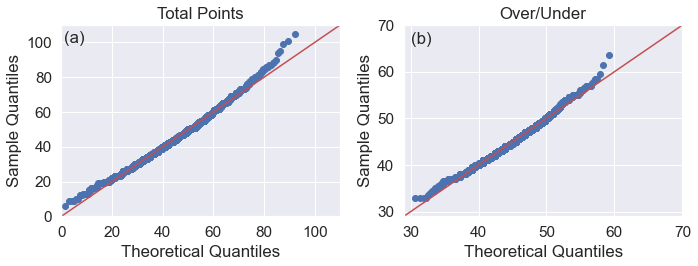

In [10]:
fig3, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
ax1.set_ylim(0,110)
ax1.set_xlim(0,110)
ax2.set_ylim(29,70)
ax2.set_xlim(29,70)
sm.qqplot(dfall['Tot_Pts'],loc=np.mean(dfall['Tot_Pts']), scale=np.std(dfall['Tot_Pts']),ax=ax1,line='45')
ax1.set_title('Total Points')
ax1.text(1,100,'(a)',fontsize='medium')
sm.qqplot(dfall['Over_Under'],loc=np.mean(dfall['Over_Under']), scale=np.std(dfall['Over_Under']),ax=ax2,line='45')
ax2.set_title('Over/Under')
ax2.text(30,66,'(b)',fontsize='medium')
fig3.tight_layout()

**As above, the** *Over/Under* **error deviates from a normal distribution only for extreme values.**

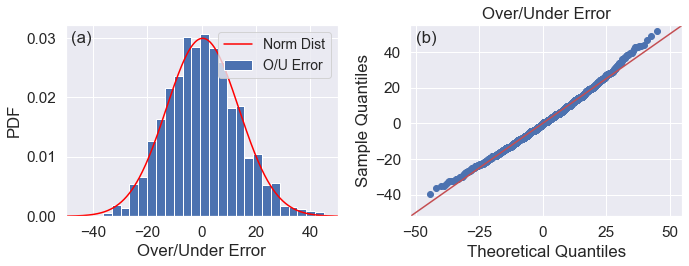

In [11]:
error = dfall['Tot_Pts'] - dfall['Over_Under']

mu = np.mean(error)
sig = np.std(error)
xx = np.linspace(-60,60,500)
yy = stats.norm.pdf(xx,loc=mu,scale=sig)
fig4, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
ax1.set_xlabel('Over/Under Error')
ax1.set_ylabel('PDF')
ax1.set_xlim(-50,50)
ax1.hist(error,bins=28,density=True,label='O/U Error')
ax1.plot(xx,yy,color='red',label='Norm Dist')
ax1.legend(loc='upper right',fontsize='small')
ax2.set_ylim(-52,55)
ax2.set_xlim(-52,52)
sm.qqplot(error,loc=mu, scale=sig,ax=ax2,line='45')
ax2.set_title('Over/Under Error')
ax1.text(-48,0.0292,'(a)',fontsize='medium')
ax2.text(-50,45,'(b)',fontsize='medium')
fig4.tight_layout()

**This set of figures show the symmetry of the error data around 0 and the larger number of positive outliers in the** *Over/Under* **error.**

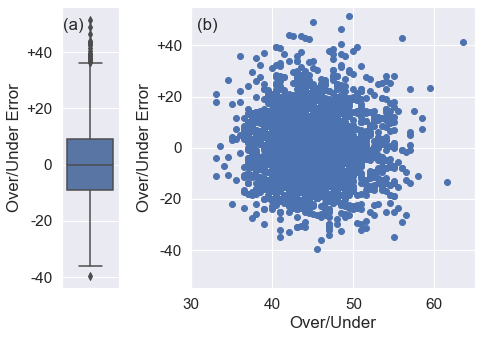

In [15]:
fig5, (ax1,ax2) = plt.subplots(1,2,gridspec_kw={'width_ratios': [1, 5]},figsize=(7,5))
error = pd.Series(error,name='Over/Under Error')
sns.boxplot(error, orient='v',ax=ax1)
ax1.yaxis.set_major_formatter(tick.FuncFormatter(y_tk_fmt))
ax1.text(0.02,0.92,'(a)',transform=ax1.transAxes,fontsize='medium')
error = dfall['Tot_Pts'] - dfall['Over_Under']
ax2.set_ylim(-55,55)
ax2.set_xlim(30,65)
ax2.set_xlabel('Over/Under')
ax2.set_ylabel('Over/Under Error')
ax2.scatter(dfall['Over_Under'],error)
ax2.yaxis.set_major_formatter(tick.FuncFormatter(y_tk_fmt))
ax2.text(0.02,0.92,'(b)',transform=ax2.transAxes,fontsize='medium')
fig5.tight_layout()

**Pie chart of Over vs. Under Wins, showing the evenness of the two results over the past decade.** 

The median and average errors for the Over are 9.0 and 11.1 points
The median and average errors for the Under are -9.0 and -10.3 points


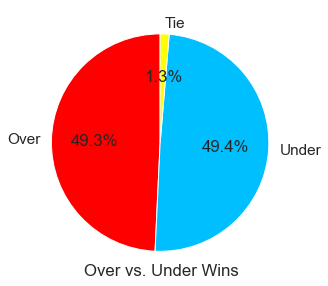

In [16]:
fig6, ax1 = plt.subplots(1,1,figsize=(12,5)) 
o_u = np.array([(dfall['Tot_Pts'] > dfall['Over_Under']).sum(),
                (dfall['Tot_Pts'] < dfall['Over_Under']).sum(),
                 (dfall['Tot_Pts'] == dfall['Over_Under']).sum()])
labels = 'Over','Under','Tie'
colors = ('red','deepskyblue','yellow')
ax1.pie(o_u/sum(o_u),labels=labels,autopct='%1.1f%%',radius=1.0,colors=colors,
        startangle=90)
ax1.text(0.22,0.01,'Over vs. Under Wins',transform=ax1.transAxes)
fig6.show()
pos = error[error > 0]
neg = error[error < 0]
print('The median and average errors for the Over are {0:.1f} and {1:.1f} points'
      .format(pos.median(),pos.mean()))
print('The median and average errors for the Under are {0:.1f} and {1:.1f} points'
      .format(neg.median(),neg.mean()))

### B. Impact of Week & Game Conditions

**Looking at the Over vs. Under on a weekly basis, a significant difference is evident in the Over % in Weeks 1-10 versus Weeks 11-17.** 

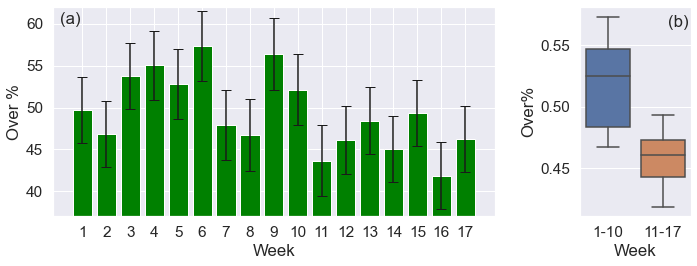

In [21]:
# Calculate percentage of 'Overs' by year 
year = pd.DataFrame(index=dfall.index,columns=['Year'])
for ind in dfall.index: 
    year.loc[ind,'Year'] = int(get_year(ind))
    year.loc[ind,'Team'] = ind[-3:]
year['Over'] = dfall['Tot_Pts'] > dfall['Over_Under']
over_count_year = year['Over'].groupby(year.Year).mean()
year['Week'] = dfall['Week']
over_count_week = year['Over'].groupby(year.Week).mean()
ave = np.mean(over_count_year.values*100)
wk_overs = pd.DataFrame(over_count_week.values,columns=['Over%'])
wk_overs.loc[0:9,'Week'] = '1-10'
wk_overs.loc[10:16,'Week'] = '11-17'

fig7, (ax1,ax2) = plt.subplots(1,2,gridspec_kw={'width_ratios': [4, 1]},figsize=(10,4))
ax1.set_xlabel('Week')
ax1.set_ylabel('Over %')
err = 100*np.sqrt(0.5*0.5/year['Over'].groupby(year.Week).count())
ax1.bar(range(1,18),over_count_week.values*100,color='green',yerr=err,capsize=5,
       tick_label=[str(i) for i in range(1,18)])
ax1.set_ylim(37,62)
ax1.text(0.05,60,'(a)',fontsize='medium')
sns.boxplot(x='Week',y='Over%',data=wk_overs,ax=ax2,orient='v')
ax2.text(1.1,0.565,'(b)',fontsize='medium')
fig7.tight_layout()  

**An independent one-sided T-test shows the statistical significance of over winning percentage during the first ten weeks of the season.**

In [24]:
early = dfall[dfall['Week'] < 11]
late = dfall[dfall['Week'] >= 11]
res = pg.ttest(early['Tot_Pts']>early['Over_Under'],late['Tot_Pts']>late['Over_Under'],
               correction=True,tail='greater')
print(res)

               T          dof     tail     p-val        CI95%   cohen-d  \
T-test  2.991491  2360.089423  greater  0.001402  [0.03, inf]  0.119457   

         BF10     power  
T-test  7.625  0.910636  


**While** *Over/Under* **stays relatively constant throughout the season,** *Total Points* **drops off later in the season, in accordance with fall-off in** *Passing Yards* **and** *Temperature*.

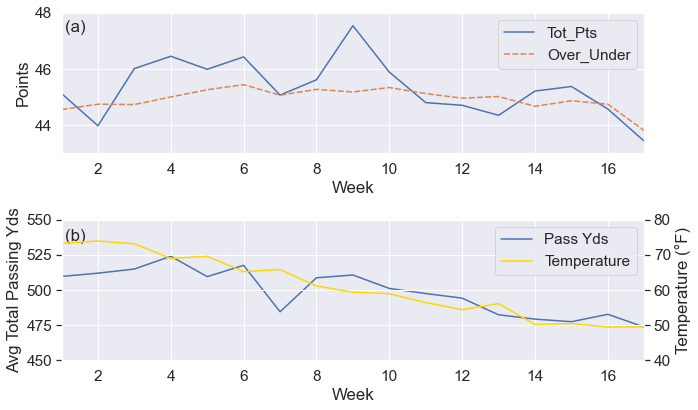

In [25]:
pyds = dfall[['H_Off_Pass','V_Off_Pass','Wind','Temperature','Week']].rename({'H_Off_Pass':'Home_Pass_Yds',
                                                                              'V_Off_Pass':'Vis_Pass_Yds'},axis=1)
pyds['Tot_Pass_Yds'] = pyds['Home_Pass_Yds'] + pyds['Vis_Pass_Yds']
for col in pyds.columns: pyds[col]=pd.to_numeric(pyds[col])

wind_by_week = pyds['Wind'].groupby(pyds.Week).mean()
temp_by_week = pyds['Temperature'].groupby(pyds.Week).mean()

tp=dfall[['Tot_Pts','Over_Under','Week']]
tp['Pass_Yds'] = dfall['H_Off_Pass'] + dfall['V_Off_Pass']
tp['Rush_Yds'] = dfall['H_Off_Rush'] + dfall['V_Off_Rush']
tppivot=pd.pivot_table(tp,index=['Week'],values=['Tot_Pts','Over_Under','Pass_Yds','Rush_Yds'],aggfunc='mean')


fig8 = plt.figure(figsize=(10,6))
_ = fig8.add_subplot(2,1,1)
_ = sns.lineplot(data=tppivot[['Tot_Pts','Over_Under']])
_ = plt.xlim(1,17)
_ = plt.ylim(43,48)
_ = plt.ylabel('Points')
_ = plt.text(1.1,47.3,'(a)',fontsize='medium')
ax1 = fig8.add_subplot(2,1,2)
ax1.plot(tppivot.index,tppivot['Pass_Yds'],label='Pass Yds')
ax1.set_xlabel('Week')
ax1.set_ylabel('Avg Total Passing Yds')
ax1.text(1.1,535,'(b)',fontsize='medium')
ax1.set_ylim(450,550)
ax1.set_xlim(1,17)
ax2 = ax1.twinx()
ax2.plot(range(1,18),temp_by_week,color='gold',label='Temperature')
ax2.set_ylabel('Temperature (°F)')
ax2.set_ylim(40,80)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')
fig8.tight_layout()  
fig8.show()

**Passing yards peaks at temperatures between 60° and 70°, showing a marked fall-off at lower temperatures.**

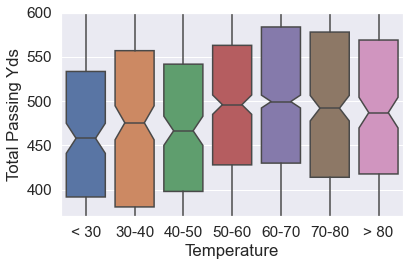

In [26]:
fig9 = plt.figure(figsize=(6,4))
_ = fig9.add_subplot(1,1,1)
bins = [-10,30,40,50,60,70,80,100]
pyds['Bin'] = pd.cut(pyds.Temperature,bins)
sns.boxplot(x='Bin',y='Tot_Pass_Yds',data=pyds,
            notch=True).set(xlabel='Temperature',ylim=(370,600),
                            ylabel='Total Passing Yds',xticklabels=['< 30','30-40','40-50','50-60','60-70','70-80','> 80'])
plt.tight_layout()
plt.show()

*Wind* **also has a very significant effect on** *Total Score,* **whereas the dome effect is less than what is considered in the** *Over/Under*.

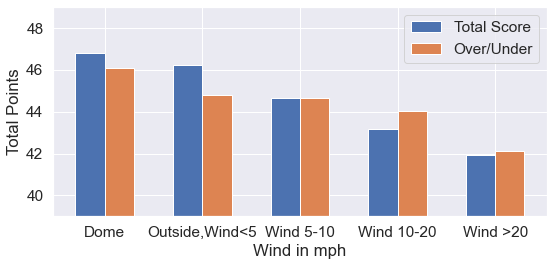

In [27]:
domed = dfall[dfall['dome'] == 1]
outside = dfall[dfall['dome'] == 0]

tpmean = (domed['Tot_Pts'].mean(),
          outside[(outside['Wind']<=5)]['Tot_Pts'].mean(),
          outside[((outside['Wind']>5) & (outside['Wind']<=10))]['Tot_Pts'].mean(),
          outside[((outside['Wind']>10) & (outside['Wind']<=20))]['Tot_Pts'].mean(),
          outside[(outside['Wind']>20)]['Tot_Pts'].mean())
oumean = (domed['Over_Under'].mean(),
          outside[(outside['Wind']<=5)]['Over_Under'].mean(),
          outside[((outside['Wind']>5) & (outside['Wind']<=10))]['Over_Under'].mean(),
          outside[((outside['Wind']>10) & (outside['Wind']<=20))]['Over_Under'].mean(),
          outside[(outside['Wind']>20)]['Over_Under'].mean())

fig10 = plt.figure(figsize=(8,4))
ax = fig10.add_subplot(1,1,1)

ind = np.arange(5)  # the x locations for the groups
width = 0.3  # the width of the bars

sns.set(font_scale=1.4)
_ = plt.bar(ind - width/2, tpmean, width, label='Total Score')
_ = plt.bar(ind + width/2, oumean, width, label='Over/Under')

# Add some text for labels, title and custom x-axis tick labels, etc.
_ = plt.ylabel('Total Points')
#_ = plt.title('Average Points by Location')
_ = plt.xticks(ind,labels=('Dome','Outside,Wind<5','Wind 5-10','Wind 10-20','Wind >20'))
_ = plt.xlabel('Wind in mph')
_ = plt.legend(loc='upper right')
_ = plt.ylim(39,49)
fig10.show()
fig10.tight_layout()

### C. Outliers & Leverage

**Influence plot showing the highly influential observations are primarily outliers**

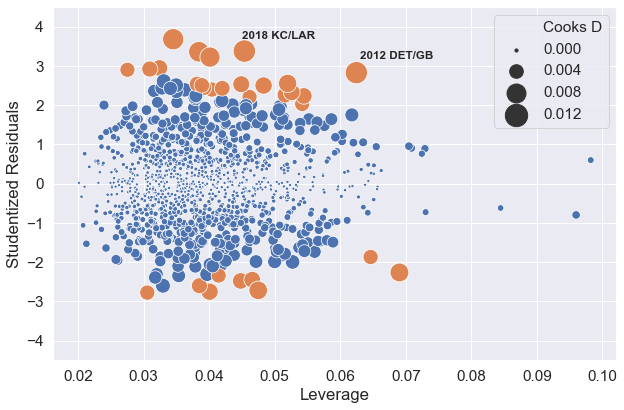

In [31]:
X = dfgame.drop(['Tot_Pts','Over_Under','Home_Team','Vis_Team','H_Game','V_Game'],axis=1)
X = X.drop(['a_turf','astroplay','fieldturf','sportturf','matrixturf','Week','Year'],axis=1)
y = dfgame['Tot_Pts']
X_train, X_test, y_train, y_test = tt_split(X, y, train_ratio=0.7, seed=37, val=False)
model = sm.OLS(y_train, X_train).fit()

influence = model.get_influence()
inf = influence.summary_frame()
resid = influence.resid_studentized_external
leverage = influence.hat_matrix_diag
inf_pts = pd.DataFrame({'resid':resid,'leverage':leverage},index=inf.index)
inf_pts['cooks'] = inf['cooks_d']
inf_pts['influence'] = inf_pts['cooks'] > (inf_pts['cooks'].mean()+3.0*inf_pts['cooks'].std())

fig11, ax = plt.subplots(1,1,figsize=(9,6))
sns.scatterplot(x='leverage', y='resid', data=inf_pts, size='cooks',sizes=(10,500),hue='influence')
handles, labels = ax.get_legend_handles_labels()
ax.set_xlabel('Leverage')
ax.set_ylabel('Studentized Residuals')
ax.set_ylim(-4.5,4.5)
ax.text(0.045,3.68,'2018 KC/LAR',fontsize='x-small',fontweight='bold')
ax.text(0.063,3.17,'2012 DET/GB',fontsize='x-small',fontweight='bold')
labels[3] = 'Cooks D'
ax.legend(handles=handles[3:],labels=labels[3:])
fig11.tight_layout()

### Summary

- *Total Points* **and** *Over/Under* **show a normal distribution with** *Total Points* **exhibiting a much greater range and a** *Total Points,Over/Under* **correlation of ~0.3**
- **Outliers in** *Over/Under* **error preside primarily to the upside**
- **Over tends to win more in first 10 weeks of season, while Under is more predominant in last 7 weeks**
- **Temperature has a significant effect on passing yards, which affects** *Total Points* **output**
- *Wind* **also has a significant effect on** *Total Points*, **with lack thereof the main cause of higher point totals in dome contests**  